In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pytidycensus as tc
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [147]:
pd.set_option("display.max_columns", None)

In [148]:

tc.set_census_api_key("3d33dd56fa8e81fd42e039aadf43b9676976f27c")

variables = {
    "B01003_001E": "total_population",              
    "B01002_001E": "median_age",

    #race
    "B02001_002E": "white",                
    "B02001_003E": "black",  
    "B02001_004E" : "native",
    "B02001_005E" : "asian",
    "B03003_003E": "hispanic",  
    "B02001_006E" : "pacific_islander",
    "B02001_007E" : "other",
    "B02001_008E" : "two_or_more_races",

    #citizen/birthplace/geographic mobility
    "B05001_006E" : "not_citizen",
    "B06001_013E": "born_in_nc",
    "B06001_037E": "born_outside_us",
    "B06007_005E": "english_less_than_well", 
    "B07001_001E": "geographically_mobile",
    "B07001_065E": "moved_from_diff_state",
    "B07001_081E": "moved_from_abroad",

    #education
    "B15003_017E": "hs_diploma",
    "B15003_018E": 'ged',
    "B15003_020E": 'some_college',
    "B15003_021E": 'associates_degree',
    "B15003_022E": 'bachelors_degree',
    "B15003_023E": 'masters_degree',
    "B15003_024E": "professional_degree",
    "B15003_025E": "doctorate_degree",
    
    #travel method
    "B08301_002E": "drove_alone",
    "B08301_003E": "carpooled",
    "B08301_010E": "public_transit",
    "B08301_011E": "walked",
    "B08301_012E": "other_means",
    "B08301_013E": "worked_from_home",

    # Travel time to work
    "B08303_002E": "commute_less_5",
    "B08303_003E": "commute_5_to_9",
    "B08303_004E": "commute_10_to_14",
    "B08303_005E": "commute_15_to_19",
    "B08303_006E": "commute_20_to_24",
    "B08303_007E": "commute_25_to_29",
    "B08303_008E": "commute_30_to_34",
    "B08303_009E": "commute_35_to_39",
    "B08303_010E": "commute_40_to_44",
    "B08303_011E": "commute_45_to_59",
    "B08303_012E": "commute_60_or_more",

    #incomes
    "B19001_002E": "income_less_than_10k",
    "B19001_003E": "income_10k_to_14_9k",
    "B19001_004E": "income_15k_to_19_9k",
    "B19001_005E": "income_20k_to_24_9k",
    "B19001_006E": "income_25k_to_29_9k",
    "B19001_007E": "income_30k_to_34_9k",
    "B19001_008E": "income_35k_to_39_9k",
    "B19001_009E": "income_40k_to_44_9k",
    "B19001_010E": "income_45k_to_49_9k",
    "B19001_011E": "income_50k_to_59_9k",
    "B19001_012E": "income_60k_to_74_9k",
    "B19001_013E": "income_75k_to_99_9k",
    "B19001_014E": "income_100k_to_124_9k",
    "B19001_015E": "income_125k_to_149_9k",
    "B19001_016E": "income_150k_to_199_9k",
    "B19001_017E": "income_200k_or_more"
    
}

year = 2023
gdf = tc.get_acs(
    geography="county",
    variables=list(variables.keys()),
    state="NC",
    year=year,
    output="wide",    
    geometry=True  
)

#drop columns for margin of error (only keep estimate)
moe_cols = [col for col in gdf.columns if col.endswith("e")]
gdf = gdf.drop(columns = moe_cols)


#rename columns from variable key to statistic
gdf = gdf.rename(columns={var: name for var, name in variables.items()})

Census API key has been set for this session.
Getting data from the 2019-2023 5-year ACS
Large table request: 116 variables will be retrieved in chunks


In [149]:
#drop unnecessary columns, locate geometry at end
gdf = gdf.drop(columns=['NAME', 'GEOID', 'county'])

#scale columns
cols_to_normalize = [c for c in gdf.columns if c != 'NAMELSAD' and c != 'total_population' and c != 'median_age' and c != 'geometry']
for c in cols_to_normalize:
    gdf[c] = gdf[c]/gdf['total_population']       

#log-transform and z-score other columns
gdf['total_population'] = np.log1p(gdf['total_population'])
gdf['median_age'] = np.log1p(gdf['median_age'])

gdf['total_population'] = StandardScaler().fit_transform(gdf[['total_population']])
gdf['median_age'] = StandardScaler().fit_transform(gdf[['median_age']])

In [150]:
income_cols = ["income_less_than_10k","income_10k_to_14_9k","income_15k_to_19_9k","income_20k_to_24_9k","income_25k_to_29_9k",
               "income_30k_to_34_9k","income_35k_to_39_9k","income_40k_to_44_9k","income_45k_to_49_9k","income_50k_to_59_9k",
               "income_60k_to_74_9k","income_75k_to_99_9k","income_100k_to_124_9k","income_125k_to_149_9k","income_150k_to_199_9k",
               "income_200k_or_more"]

race_cols = ["white", "black","native","asian","hispanic","pacific_islander","other","two_or_more_races"]

citizen_cols = ["not_citizen","born_in_nc","born_outside_us","english_less_than_well",
                "geographically_mobile","moved_from_diff_state","moved_from_abroad"]

education_cols = ["hs_diploma",'ged','some_college','associates_degree','bachelors_degree','masters_degree', "professional_degree","doctorate_degree"]

travel_method_cols = ["drove_alone","carpooled","public_transit","walked","other_means","worked_from_home"]

commute_time_cols = ["commute_less_5","commute_5_to_9","commute_10_to_14","commute_15_to_19","commute_20_to_24","commute_25_to_29","commute_30_to_34",
                     "commute_35_to_39","commute_40_to_44","commute_45_to_59","commute_60_or_more"]

#transform all columns using pca and drop old cols

pca_income = PCA(n_components = 2)
gdf[['income_transform1','income_transform2']] = pca_income.fit_transform(gdf[income_cols])
gdf = gdf.drop(columns = income_cols)

pca_race = PCA(n_components=2)
gdf[['race_transform1', 'race_transform2']] = pca_race.fit_transform(gdf[race_cols])
gdf = gdf.drop(columns=race_cols)

pca_travel = PCA(n_components = 2)
gdf[['travel_transform1','travel_transform2']] = pca_travel.fit_transform(gdf[travel_method_cols])
gdf = gdf.drop(columns = travel_method_cols)

pca_citizen = PCA(n_components = 2)
gdf[['citizen_transform1','citizen_transform2']] = pca_citizen.fit_transform(gdf[citizen_cols])
gdf = gdf.drop(columns = citizen_cols)

pca_education = PCA(n_components = 2)
gdf[['education_transform1','education_transform2']] = pca_education.fit_transform(gdf[education_cols])
gdf = gdf.drop(columns = education_cols)

pca_commute = PCA(n_components = 2)
gdf[['commute_transform1','commute_transform2']] = pca_commute.fit_transform(gdf[commute_time_cols])
gdf = gdf.drop(columns =  commute_time_cols)



In [151]:
#view standard deviations for weighting (mean of all columns is =~ 0)
sds = {}
for column in gdf.columns[2:]:
    sds[column] = gdf[column].std()
sds

{'total_population': 1.0050378152592119,
 'median_age': 1.0050378152592123,
 'income_transform1': 0.02134939175946955,
 'income_transform2': 0.010145438252990737,
 'race_transform1': 0.23291761494863075,
 'race_transform2': 0.06626811526984708,
 'travel_transform1': 0.041824587784928785,
 'travel_transform2': 0.006413074334987001,
 'citizen_transform1': 0.13584529765772935,
 'citizen_transform2': 0.026527071045492637,
 'education_transform1': 0.05640610972459107,
 'education_transform2': 0.02026896266439307,
 'commute_transform1': 0.026436321637076942,
 'commute_transform2': 0.01780265348075952}

In [152]:
#weight columns
gdf['total_population'] = gdf['total_population']
gdf['median_age'] = gdf['median_age']

gdf[['income_transform1','income_transform2']] = 100 * gdf[['income_transform1','income_transform2']]
gdf[['race_transform1','race_transform2']] = 10 * gdf[['race_transform1','race_transform2']]
gdf[['travel_transform1','travel_transform2']] = 10 * gdf[['travel_transform1','travel_transform2']]
gdf[['citizen_transform1','citizen_transform2']] = 20 * gdf[['citizen_transform1','citizen_transform2']]
gdf[['education_transform1','education_transform2']] = 20 * gdf[['education_transform1','education_transform2']]
gdf[['commute_transform1','commute_transform2']] = 10 * gdf[['commute_transform1','commute_transform2']]

In [153]:
gdf.head()

,geometry,NAMELSAD,total_population,median_age,income_transform1,income_transform2,race_transform1,race_transform2,travel_transform1,travel_transform2,citizen_transform1,citizen_transform2,education_transform1,education_transform2,commute_transform1,commute_transform2
0,"MULTIPOLYGON (((-77.171 34.626, -77.169 34.627...",Onslow County,1.203390,-3.604432,0.263056,0.658584,0.539288,0.509900,0.259321,-0.173615,-5.835410,-0.526197,0.225416,-0.887430,0.272752,0.036766
1,"POLYGON ((-81.741 36.413, -81.737 36.414, -81....",Ashe County,-0.631642,1.180627,-1.867477,0.116953,3.169848,-0.385110,-0.241221,0.003083,1.238721,-0.344444,-0.409776,0.431921,0.089265,0.045032
2,"POLYGON ((-80.45 36.328, -80.45 36.339, -80.44...",Stokes County,-0.171105,0.822852,-0.769620,2.098489,2.818707,-0.476419,0.418390,0.059590,2.010339,-0.594708,-1.075862,0.427784,-0.424856,0.111632
3,"POLYGON ((-76.313 36.551, -76.313 36.551, -76....",Currituck County,-0.543388,-0.223046,4.512818,0.343272,2.279392,-0.230202,1.052125,-0.097181,-8.268361,-0.639921,0.196169,0.747904,-0.676024,-0.215791
4,"POLYGON ((-83.949 35.461, -83.943 35.465, -83....",Swain County,-1.209605,-0.054488,-0.328469,-0.324520,0.597802,2.748961,-0.169838,0.037191,1.342198,-0.639361,-0.632264,-0.090318,0.394727,-0.039930


In [154]:
#cosine similarity to get edge weights
def similarity(co1, co2):
    c1 = np.array(gdf[gdf['NAMELSAD'] == co1].iloc[:,2:])  #don't need first 2 observations (county name and population)
    c2 = np.array(gdf[gdf['NAMELSAD'] == co2].iloc[:,2:]).T
    return 1 - np.arccos((np.dot(c1,c2)/(np.linalg.norm(c1) * np.linalg.norm(c2)))[0,0])/np.pi

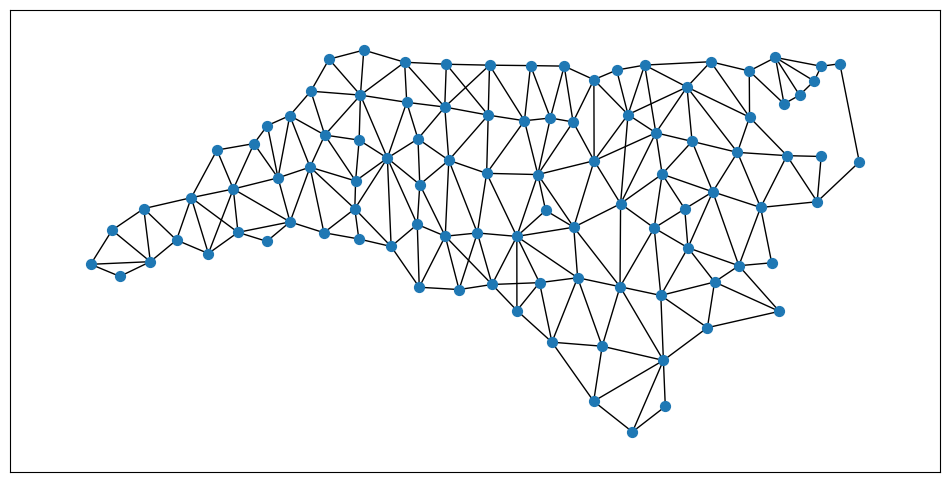

In [155]:
#build adjacencies on graph
G = nx.Graph()

#create nodes
for idx, county in gdf.iterrows():
    G.add_node(county["NAMELSAD"], geometry = county.geometry)

#create edges
for i, co1 in gdf.iterrows():
    for j, co2 in gdf.iterrows():
        if i<j and co1.geometry.touches(co2.geometry):
            G.add_edge(co1['NAMELSAD'], co2['NAMELSAD'])

#weights for edges based on similarity function
for co1, co2 in G.edges():
    G[co1][co2]['weight'] = similarity(co1,co2)


#position dictionary for graph
pos = {
    county['NAMELSAD']: (county.geometry.centroid.x, county.geometry.centroid.y) for _,county in gdf.iterrows()
}


#build graph
fig, ax = plt.subplots(figsize = (12,6))

nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50)

plt.savefig('full_graph.png')

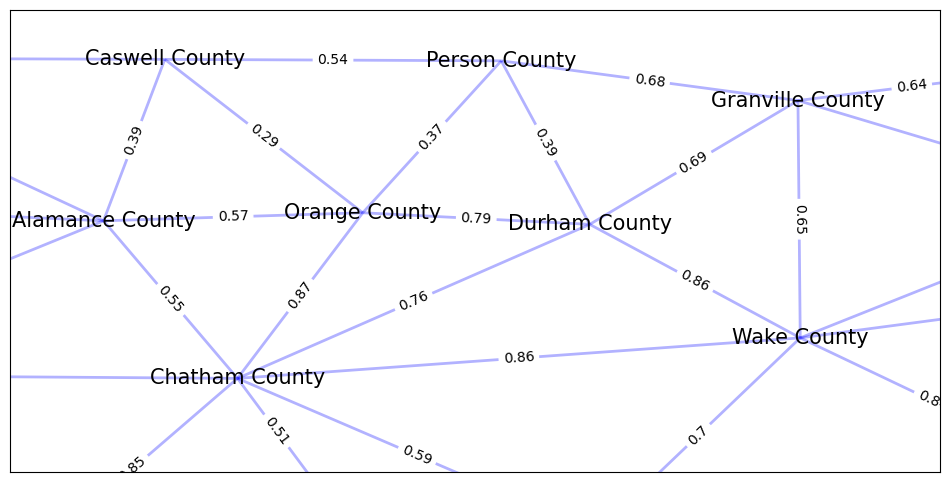

In [156]:
#demonstrated graph with weights
fig, ax = plt.subplots(figsize = (12,6))

#nx.draw_networkx_nodes(G, pos, ax = ax, node_size = 50)
nx.draw_networkx_edges(G, pos, ax = ax, width = 2, alpha = 0.3, edge_color = 'blue')
nx.draw_networkx_labels(G, pos, ax = ax, font_size = 15)

edge_weights = {edge: round(weight,2) for edge, weight in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_weights, ax = ax, font_size = 10)

plt.xlim(-79.5,-78.5)
plt.ylim(35.5,36.5)
plt.savefig('weights_example.png')
plt.show()

In [157]:
# adjacency matrix with weights
W = nx.to_numpy_array(G, weight='weight')

# compute laplacian
D = np.diag(W.sum(axis=1))
L = D - W

# compute bottom-k eigenvectors
k = 14
eigvals, eigvecs = np.linalg.eigh(L)
U = eigvecs[:, :k] #get first k eigenvectors

# k-means clustering
clusters = KMeans(n_clusters=k, n_init='auto').fit_predict(U)

# attatch cluster label to nodes
for node, cluster in zip(list(G.nodes),clusters):
    G.nodes[node]['district'] = int(cluster)

C:\Users\olubl\anaconda3\envs\spatialdata\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


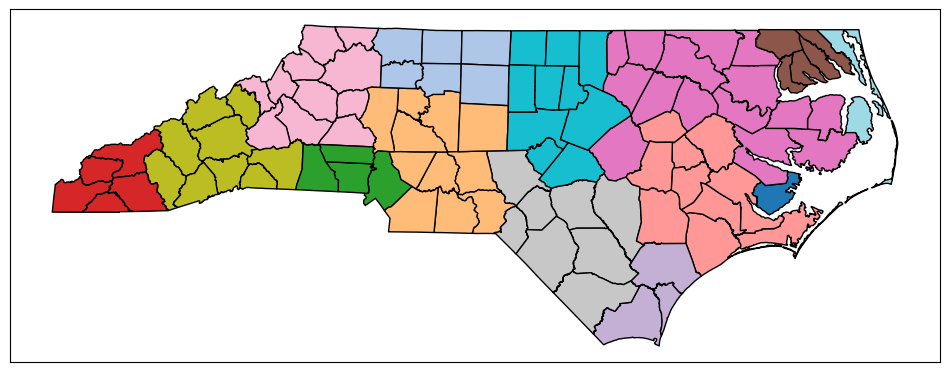

In [158]:
gdf_copy = gdf.copy()
gdf_copy["district"] = gdf_copy["NAMELSAD"].map(lambda x: G.nodes[x]["district"])

fig, ax = plt.subplots(figsize = (12,8))
gdf_copy.plot(column="district", cmap="tab20", ax = ax, legend=False, edgecolor="black")

plt.savefig("clustered_counties.png")

ax.set_yticks([])
ax.set_xticks([])
plt.show()